In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sklearn.metrics as metrics
import seaborn as sns
from tensorflow.keras import datasets, layers, models
from captcha_generator import CaptchaGenerator, rotate_back
from preprocess import convert2gray, convert2binaryimg, noise_elimination, img_segmentation
from cnn import CNN
from predict import Predict
import matplotlib.pyplot as plt
%matplotlib inline


# Generate Data Set

In [2]:
def generate_single_captcha(number):
    for i in range(number):    
        a = CaptchaGenerator(60, 60)
        c = a.generate(1, 'mixture')
        d = convert2gray(c.get_captcha_array())
        string = c.get_captcha_string()
        image = Image.fromarray(d.astype(np.uint8))
        image = convert2binaryimg(image)
        img_array = np.where(np.array(image), 255, 0)
        noise_elimination(img_array)
        subImg_list = img_segmentation(img_array)
        if len(subImg_list) == 0:
            continue
        img = subImg_list[0]
        img = np.pad(img, ((10,10),(10,10)),'constant',constant_values=(255, 255))
        img = 255 - img
        im = Image.fromarray(img.astype(np.uint8))
        im = im.resize((28,28),Image.ANTIALIAS)
        random_name = np.random.random()

        if not os.path.exists('dataset_char/{}'.format(string.upper())):
            os.makedirs('dataset_char/{}'.format(string.upper()))
        path = 'dataset_char/{}/{}.jpg'.format(string.upper(), random_name)
        im.save(path)
        if np.random.random()>0.5:
            rotate_back(path)

        if (i+1)%1000 == 0:
            print('has generated {} single captcha images.'.format(i+1))

In [3]:
# It may take long time if number is too large, but can obtain a better training performance!(>=300000)
generate_single_captcha(1000)

has generated 1000 single captcha images.


# Load, Preprocess and Generate Data and Labels

## Character Map

In [4]:
# match characters to labels
M = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'J': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 18, 'V': 19, 'W': 20, 'X': 21, 'Y': 22, 'Z': 23, '0': 24, '1': 25, '2': 26, '3': 27, '4': 28, '5': 29, '6': 30, '7': 31, '8': 32, '9': 33}

## Start from the Original Images

In [5]:
# Given root directory, return a list of file names in it.
def get_imgs(rootdir):
    fs = [] 
    for root, dirs, files in os.walk(rootdir,topdown = True):  
        for name in files:  
            _, ending = os.path.splitext(name)  
            if ending == ".jpg":  
                fs.append(os.path.join(root,name))
    return fs

In [6]:
root_path = 'dataset_char/'

print("reading data and labels...")
data = []
labels = []
for char in M:
    imgs = get_imgs(root_path + char)
    for i in range(len(imgs)):
        labels.append(M[char])

        image = Image.open(imgs[i]).convert('L')
        image = convert2binaryimg(image)
        img = np.where(np.array(image), 255, 0)
        im = Image.fromarray(img.astype(np.uint8))
        im = im.resize((28,28),Image.ANTIALIAS)
        img = np.array(im)

        img = np.reshape(img,(28,28,1))/255.0

        data.append(img)

data = np.array(data)
labels = np.array(labels)
print("done!")
print("generating train set and test set...")

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state=42)
print("done!")

reading data and labels...
done!
generating train set and test set...
done!


## Start from the 'npy' Format Data Set 

In [7]:
# you need to unzip the file named 'dataset.zip' yourself first!
data, labels = np.load('dataset/X.npy'), np.load('dataset/Y.npy')
print("Dataset contains {} images and {} labels.".format(len(data), len(labels)))

print("generating train set and test set...")
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state=42)
print("done!")

Dataset contains 554707 images and 554707 labels.
generating train set and test set...
done!


# Train the CNN

## Create the CNN Model and Start Training

In [8]:
cnn = CNN()
check_path = './ckpt/cp-{epoch:04d}.ckpt'
save_model_cb = tf.keras.callbacks.ModelCheckpoint(check_path, save_weights_only=True, verbose=1, period=5)

cnn.model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
history = cnn.model.fit(x_train, y_train, epochs=5, callbacks=[save_model_cb], validation_split=0.25, verbose=1)

test_loss, test_acc = cnn.model.evaluate(x_test, y_test)
print("Accuracy: %.4f，testing %d images " % (test_acc, len(y_test)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

## Training Accuracy and Validation Accuracy

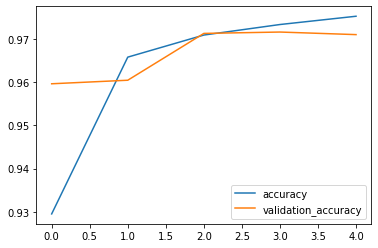

In [9]:
plt.plot(history.epoch, history.history.get('accuracy'), label = 'accuracy')
plt.plot(history.epoch, history.history.get('val_accuracy'), label = 'validation_accuracy')
plt.legend()

## Training Loss and Validation Loss

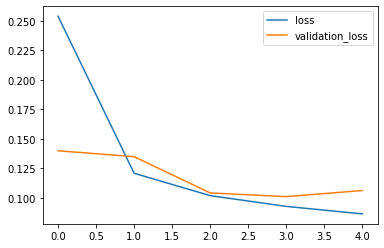

In [10]:
plt.plot(history.epoch, history.history.get('loss'), label = 'loss')
plt.plot(history.epoch, history.history.get('val_loss'), label = 'validation_loss')
plt.legend()

## Confusion Matrix

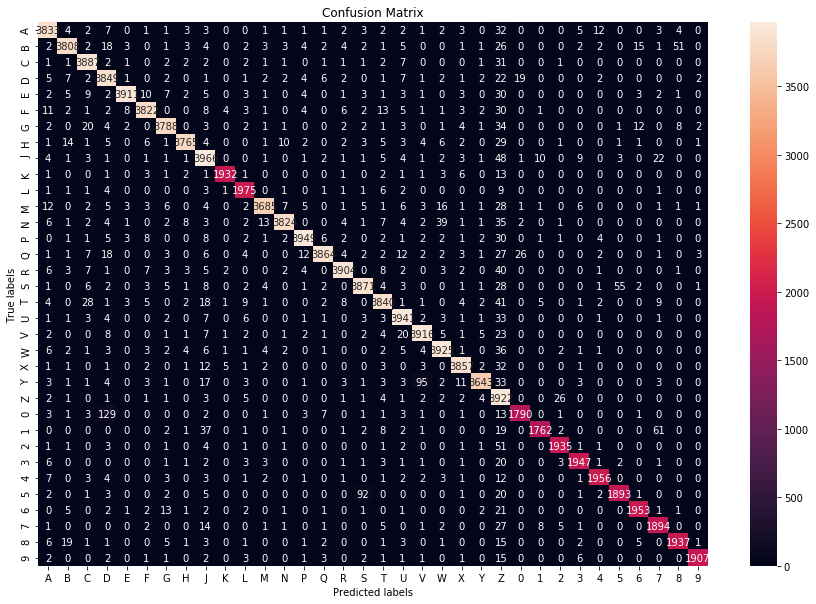

In [11]:
y_pred = cnn.model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(15,10))    
sns.heatmap(confusion_matrix, annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
x = ax.xaxis.set_ticklabels(list(M.keys()))
x = ax.yaxis.set_ticklabels(list(M.keys()))

## Classification Report

In [12]:
print(metrics.classification_report(y_true=y_test, y_pred=y_pred, target_names=list(M.keys()), zero_division=1))

              precision    recall  f1-score   support

           A       0.97      0.98      0.97      3929
           B       0.98      0.96      0.97      3966
           C       0.97      0.98      0.98      3947
           D       0.94      0.98      0.96      3943
           E       0.99      0.98      0.98      4009
           F       0.98      0.97      0.98      3930
           G       0.98      0.97      0.98      3894
           H       0.99      0.97      0.98      3868
           J       0.95      0.97      0.96      4093
           K       0.99      0.98      0.99      1969
           L       0.97      0.98      0.98      2008
           M       0.99      0.97      0.98      3807
           N       0.99      0.96      0.98      3963
           P       0.99      0.98      0.98      4035
           Q       0.99      0.97      0.98      4003
           R       0.99      0.98      0.98      4004
           S       0.97      0.97      0.97      4002
           T       0.97    

# Predict

## Generate 4-character Captchas

In [13]:
def generate_captchas(number):
    for i in range(number):
        a = CaptchaGenerator(160, 60)
        a.generate(4, 'mixture', save=True)

In [14]:
generate_captchas(2000)

## Visualize Original Captchas

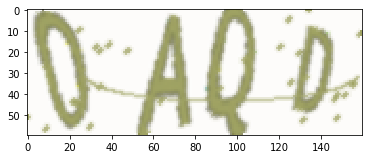

In [15]:
image = Image.open('dataset_captcha/4/mixture/0AQD.jpg')
img = np.array(image)
plt.imshow(img)

## Preprocess and Segement Images

- **Convert into binary image**

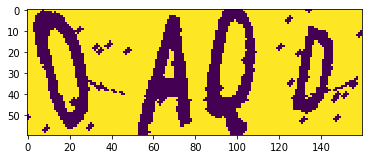

In [16]:
img = image.convert('L')
img = convert2binaryimg(img)
img_array = np.where(np.array(img), 255, 0)
plt.imshow(img_array)

- **Eliminate noises**

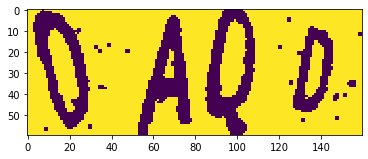

In [17]:
noise_elimination(img_array)
plt.imshow(img_array)

- **Segment images**

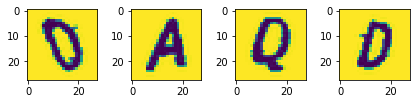

In [18]:
fig = plt.figure()
subImg_list = img_segmentation(img_array)
for i in  range(len(subImg_list)):
    img = subImg_list[i]
    img = np.pad(img, ((10,10),(10,10)),'constant',constant_values=(255, 255))
    im = Image.fromarray(img.astype(np.uint8))
    im = im.resize((28,28),Image.ANTIALIAS)
    img = np.array(im)
    fig.add_subplot(1, 4, i+1)
    plt.tight_layout()
    plt.imshow(img)

## Recognise Captchas

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

'0AQD'

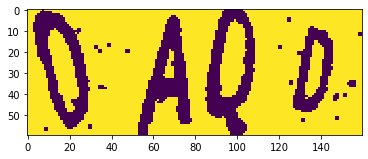

<Figure size 432x288 with 0 Axes>

In [19]:
predictor = Predict()
predictor.predict('dataset_captcha/4/mixture/0AQD.jpg')

## Evaluation for 4-Character Captcha Recognition

In [20]:
def get_fileNames(rootdir):  
    paths = [] 
    res = []
    for root, dirs, files in os.walk(rootdir,topdown = True):  
        for name in files:  
            _, ending = os.path.splitext(name)  
            if ending == ".jpg":  
                paths.append(os.path.join(root,name))
                res.append(name.split('.')[0])
    return paths,res

In [21]:
paths,names = get_fileNames('dataset_captcha/4/mixture/')

correct = 0
valid = 0
mistake_dict = dict()
for i in range(len(paths)):
    res = names[i].upper()
    ans = predictor.predict(paths[i], mode='test')
    if res == ans:
        correct += 1
    if len(ans) == 4:
        valid += 1
        if res!=ans:
            for k in range(4):
                if res[k]!=ans[k]:
                    num = mistake_dict.get((res[k],ans[k]), 0)
                    mistake_dict[(res[k], ans[k])] = num +1   
        
        if valid>0 and valid%50 == 0:
            print('Valid Captchas: {}, Accuracy: {}'.format(valid, correct/(valid)), end='\r')

print('Valid Captchas: {}, Accuracy: {}'.format(valid, correct/(valid)), end='\r')

In [22]:
dict(sorted(mistake_dict.items(), key=lambda item: item[1]))

{('W', 'T'): 1,
 ('V', 'L'): 1,
 ('2', 'Z'): 1,
 ('E', 'F'): 1,
 ('F', 'T'): 1,
 ('1', 'T'): 1,
 ('E', 'G'): 1,
 ('9', 'G'): 1,
 ('N', '1'): 1,
 ('N', 'X'): 1,
 ('J', 'Y'): 1,
 ('W', 'V'): 1,
 ('D', 'Q'): 1,
 ('S', '5'): 1,
 ('1', 'J'): 1,
 ('H', 'T'): 1,
 ('A', '4'): 1,
 ('4', '3'): 1,
 ('X', 'A'): 1,
 ('G', '6'): 1,
 ('B', '0'): 1,
 ('G', '8'): 1,
 ('B', '6'): 2,
 ('W', 'U'): 2,
 ('5', 'S'): 3,
 ('7', 'J'): 3,
 ('D', '0'): 3,
 ('Y', 'V'): 4,
 ('7', '1'): 5,
 ('T', 'C'): 5,
 ('B', '8'): 6}

**From the dictionary above, we can get that the CNN can easily misidentify B as 8, T as c, 7 as 1!**